In [2]:
from dotenv import load_dotenv
from pymongo import MongoClient
import os

load_dotenv()

mongodb_uri = os.getenv("MONGO_URL1")

client = MongoClient(mongodb_uri)
print(client.list_database_names())

['Devansh', 'Image', 'ImageDB', 'JournalApp', 'Restaurant', 'admin', 'config', 'local', 'newdatabase']


In [3]:
for emp in client["FaceRec"]["ImageDB"].find():
    print(emp)
    client["FaceRec"]["VectorDB"].update_one(
        {
            "Name": emp["Name"],
            "embedding": emp["embeddings"][0],
            "Image": emp["Images"][0],
        }
    )
    print("Inserted")

In [ ]:
import FastAPI
from pymongo import MongoClient, BaseModel, ObjectId, HTTPException

In [ ]:
mongodb_uri = "mongodb://localhost:27017/"
port = 8000
client = MongoClient(mongodb_uri, port)

db = client["newdatabase"]

app = FastAPI()


class User(BaseModel):
    name: str
    tasks: dict


@app.post("/users")
async def create_user(name: str):
    db.users.insert_one({"name": name, "tasks": {}})
    return {"message": f"user {name} created successfully"}


class Task(BaseModel):
    user_id: str
    task: str
    status: bool


@app.post("/tasks")
async def create_task(user_id: str, task: str, status: bool):
    user = db.users.find_one({"_id": ObjectId(user_id)})
    if not user:
        return {"message": f"user does not exist"}
    tasks = user.get("tasks", {})
    print(tasks)
    if task in tasks:
        return {"message": f"task {task} already exists"}
    tasks[task] = status
    print(tasks)
    db.users.update_one({"_id": ObjectId(user_id)}, {"$set": {"tasks": tasks}})
    return {"message": f"task {task} created successfully"}


def fetch_tasks(user_id: str):
    user = db.users.find_one({"_id": ObjectId(user_id)})
    if user:
        user["_id"] = str(user["_id"])
        return user
    raise HTTPException(status_code=404, detail="User not found")


@app.get("/tasks")
async def get_tasks(user_id: str):
    return fetch_tasks(user_id)


@app.put("/tasks/{task}")
async def update_task(user_id: str, task: str, status: bool):
    user = db.users.find_one({"_id": ObjectId(user_id)})
    if not user:
        return {"message": f"user does not exist"}
    tasks = user.get("tasks", {})
    if task not in tasks:
        return {"message": f"task {task} does not exist"}
    tasks[task] = status
    db.users.update_one({"_id": ObjectId(user_id)}, {"$set": {"tasks": tasks}})
    return {"message": f"task {task} updated successfully"}

## Usingdeepface to extract Face and make face embeddings

### db schema
- face img
- id
- name (optional)
- age
- gender
- synthetic attributes(to be generated in future for further research)



In [3]:
from deepface import DeepFace

image_path = "Images\devansh.jpg"
extracted_face = DeepFace.extract_faces(image_path, detector_backend="mtcnn")

1/1 [==============================] - 0s 193ms/step


In [10]:
extracted_face

[{'face': array([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],

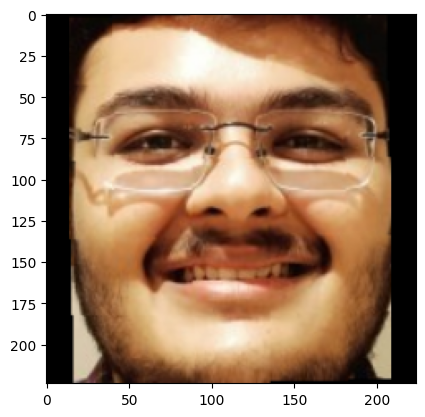

In [12]:
from matplotlib import pyplot as plt

plt.imshow(extracted_face[0]["face"])

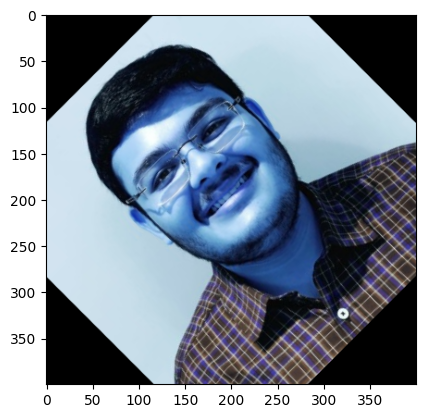

In [21]:
# give rotated image by 45 degree's as input
import cv2

img = cv2.imread(image_path)
(h, w) = img.shape[:2]
center = (w / 2, h / 2)
angle45 = 45
scale = 1.0
M = cv2.getRotationMatrix2D(center, angle45, scale)
rotated45 = cv2.warpAffine(img, M, (h, w))
plt.imshow(rotated45)

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: C:\Users\Devasy\.deepface\weights\retinaface.h5
100%|██████████| 119M/119M [00:12<00:00, 9.16MB/s] 


0.9999157190322876


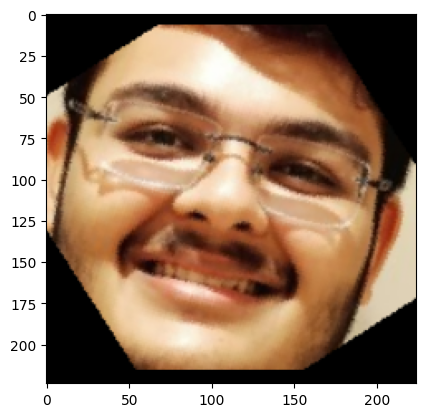

In [27]:
new_extracted_face = DeepFace.extract_faces(rotated45, detector_backend="retinaface")
print(new_extracted_face[0]["confidence"])
plt.imshow(new_extracted_face[0]["face"])

In [30]:
# embedding of extracted face
embedding = DeepFace.represent(
    rotated45, model_name="Facenet", detector_backend="retinaface"
)
embedding

[{'embedding': [-0.7613316774368286,
   0.7168868780136108,
   1.1391221284866333,
   0.0870029553771019,
   0.7235468029975891,
   -0.284409761428833,
   0.7022044658660889,
   -2.628713607788086,
   -0.8989149332046509,
   2.093172788619995,
   0.3535653054714203,
   -0.48013657331466675,
   -1.424012303352356,
   -1.462817907333374,
   -0.036128103733062744,
   1.4304324388504028,
   0.6999751329421997,
   -0.6086507439613342,
   -1.633750319480896,
   -1.6507925987243652,
   0.33205267786979675,
   -0.3876064121723175,
   -0.5627342462539673,
   -0.0436604768037796,
   -0.13403232395648956,
   0.2467590570449829,
   0.7091976404190063,
   0.7795525193214417,
   -1.0776993036270142,
   2.2203445434570312,
   0.5673094987869263,
   -0.6411224007606506,
   -1.9194210767745972,
   -0.14063020050525665,
   2.123344898223877,
   0.5725311040878296,
   -0.24147754907608032,
   0.11860524863004684,
   2.536914348602295,
   1.464136004447937,
   -0.3658997118473053,
   -0.7906534671783447,


In [34]:
import time


def log_time(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        print(f"Time taken: {end-start} by {func.__name__} {args[2]}")

    return wrapper


@log_time
def test(img, model_name, detector_backend):
    embedding = DeepFace.represent(
        img, model_name=model_name, detector_backend=detector_backend
    )
    return embedding


test(rotated45, "Facenet", "retinaface")
test(rotated45, "Facenet", "mtcnn")

Time taken: 2.467024326324463 by test retinaface
1/1 [==============================] - 0s 83ms/step
Time taken: 1.8496372699737549 by test mtcnn


## store it in db

In [4]:
import requests
import json


"""async def create_new_faceEntry(Employee: Employee):
    EmployeeCode = Employee.EmployeeCode
    Name = Employee.Name
    gender = Employee.gender
    Department = Employee.Department
    encoded_image = Employee.Image
    time = datetime.now()
    img_recovered = base64.b64decode(encoded_image)  # decode base64string
    # print(img_recovered)
    pil_image = Image.open(BytesIO(img_recovered))
    image_filename= f"{Name}.png"
    pil_image.save(image_filename)
    # print path of the current working directory
    # pil_image.save(f"Images\dbImages\{Name}.jpg")
    # Extract the face from the image
    face_image_data = DeepFace.extract_faces(image_filename, detector_backend="mtcnn",enforce_detection=False)
    # Calculate the embeddings of the face image
    # plt.imsave(f"Images/Faces/{Name}.jpg", face_image_data[0]['face'])
    embeddings = DeepFace.represent(image_filename, model_name="Facenet", detector_backend="mtcnn")
    os.remove(image_filename)
    # Store the data in the database
    db.faceEntries.insert_one({
        "EmployeeCode":EmployeeCode,
        "Name": Name,
        "gender": gender,
        "Department": Department,
        "time": time,
        "embeddings": embeddings,
        "Image": encoded_image
    })
    return {"message": "Face entry created successfully"}"""

"""class Employee(BaseModel):
    EmployeeCode: int
    Name: str
    gender:str
    Department:str
    Image:str"""

url = "http://localhost:8000/create_new_faceEntry"
# edata = {"Employee": data}

image = "Images\devansh.jpg"
import base64

with open(image, "rb") as img_file:
    encoded_string = base64.b64encode(img_file.read())

encoded_string = encoded_string.decode("utf-8")
data = {
    "EmployeeCode": "1234",
    "Name": "Devanshu",
    "gender": "Male",
    "Department": "IT",
    "Image": encoded_string,
}
response = requests.post(url, json=data)
response.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
url = "http://127.0.0.1:8000/create_new_faceEntry"
resp = requests.post(
    url=url,
    json={
        "EmployeeCode": 134,
        "Name": "Name",
        "gender": "gender",
        "Department": "Department",
        "Image": "your_image",
    },
)

In [3]:
print(resp)

<Response [500]>


In [10]:
from API.database import Database

EmployeeCode = 1
client = Database()
client.find_one(
    "faceEntries",
    filter={"EmployeeCode": EmployeeCode},
    projection={
        "Name": True,
        "gender": True,
        "Department": True,
        "Image": True,
        "_id": False,
    },
)

TypeError: Database.find_one() missing 1 required positional argument: 'query'